In [1]:
import os
import math
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import gpytorch

c:\Users\evere\anaconda3\envs\bigan\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['figure.figsize'] = [9.6, 9.6]
torch.set_printoptions(threshold=10_000)

COUNTER_FILENAME = os.path.expanduser("../bigan/model_counter.txt")
global MODEL_ID

def retrieve_model_id():
    global MODEL_ID
    try:
        with open(COUNTER_FILENAME, 'r') as f:
            count = f.read()
            MODEL_ID = count
    except FileNotFoundError:
        print('New counter file.')
        with open(COUNTER_FILENAME, 'w') as f:
            count = '0'
            f.write(count)
            MODEL_ID = count

retrieve_model_id()

LOAD_PATH =  r'..\bigan\data\activations\ae_{}'.format(MODEL_ID)
params = np.load(r'{}\params.npy'.format(LOAD_PATH))
activs = np.load(r'{}\activs.npy'.format(LOAD_PATH))
# rho, sigma, mu, c
params = torch.from_numpy(params)
# y_naught
activs = torch.from_numpy(activs)
activ0 = activs[:,0]
activ1 = activs[:,1]

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    # Returns multivariate Gaussian distribution with prior mean and prior covariance evaluated at x.
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
def symbreg_eq0(activ, params):
    activ = activ[:,0]
    sigma = params[:,1]
    mu = params[:,2]
    numer = torch.mul(sigma, 710)
    print(f'activ = {activ[0]}')
    print(f'sigma = {sigma[0]}')
    print(f'mu = {mu[0]}')
    print(f'710sigma = {numer[0]}')

    mul = 6.84 * (mu * sigma)
    add = activ + mul
    denom = activ + (6.84 * (mu * sigma))
    c_hat = numer / denom
    print(c_hat[0])
    return c_hat

def standardized_rmse(pred_dist, test_y, f_var=None, toggle=False):
    combine_dim = -1
    if not toggle:
        f_var = pred_dist.variance
    res = torch.square(pred_dist.mean - test_y)
    res = torch.div(res, f_var).mean(dim=combine_dim)
    res = torch.sqrt(res)
    return res

In [13]:
# Append all parameters & labels for random split.
# activ0, activ1, rho, sigma, mu, c
data = torch.cat((activ0[:,None], activ1[:,None], params), 1).double()
data_train, data_test = train_test_split(data, test_size=0.25, random_state=14)

# Separate into respective parameters & labels after random split.
activ0_train, activ0_test = data_train[:,0:1], data_test[:,0:1]
activ1_train, activ1_test = data_train[:,1:2], data_test[:,1:2]
params_train, params_test = data_train[:,2:5], data_test[:,2:5]
rho_train, rho_test = data_train[:,2:3], data_test[:,2:3]
sigma_train, sigma_test = data_train[:,3:4], data_test[:,3:4]
mu_train, mu_test = data_train[:,4:5], data_test[:,4:5]
c_train, c_test = data_train[:,5], data_test[:,5]

# X: activ0, sigma, mu
X_train = torch.cat((activ0_train, sigma_train, mu_train), 1)
X_test = torch.cat((activ0_test, sigma_test, mu_test), 1)
X_cat = torch.cat((X_train, X_test), 0)
X_means = X_cat.mean(dim=0, keepdim=True)
X_stds = X_cat.std(dim=0, keepdim=True)
X_train = (X_train - X_means) / X_stds
X_test = (X_test - X_means) / X_stds
    
# y: c - c_hat
c_hat_train = symbreg_eq0(activ0_train, params_train)
c_hat_test = symbreg_eq0(activ0_test, params_test)
y_train = c_train - c_hat_train
y_test = c_test - c_hat_test

sigma = params[:,1]
print(torch.min(sigma))
print(torch.max(sigma))

tensor([ 906.9900, 1272.3900, 1038.6900, 1056.2100, 1002.8700, 1486.5900,
        1021.1100, 1389.4500, 1448.1900, 1001.5500, 1497.7500,  982.1100,
        1039.1700, 1305.7500, 1159.2300, 1353.2700, 1109.7300, 1224.0300,
        1178.3100, 1474.5900, 1088.6700,  972.6900, 1435.3500, 1121.6100,
        1130.4900, 1069.9500, 1016.8500, 1082.9100, 1016.3700, 1053.9300,
        1039.9500,  951.7500, 1353.9900, 1307.2500, 1007.6100, 1267.4700,
        1411.0500,  923.0100, 1320.2700, 1254.7500, 1069.1100, 1151.7900,
        1350.3300, 1079.8500, 1097.4900,  916.3500, 1089.9300,  950.0100,
        1299.6900, 1444.1700, 1049.7900, 1326.0300, 1419.0300, 1061.8500,
        1089.8100, 1484.7900, 1407.3900, 1453.2900, 1407.2100, 1278.3300,
        1287.0300,  943.7700, 1456.9500, 1182.5700, 1244.1900,  959.2500,
        1444.8300,  907.7700,  958.6500, 1429.3500, 1216.9500, 1417.7700,
        1093.4700, 1020.5700, 1080.8100, 1435.4100, 1223.7300, 1328.0700,
        1036.8300, 1486.1100, 1100.670

(-401.9686535505582, 14233.565997099946)

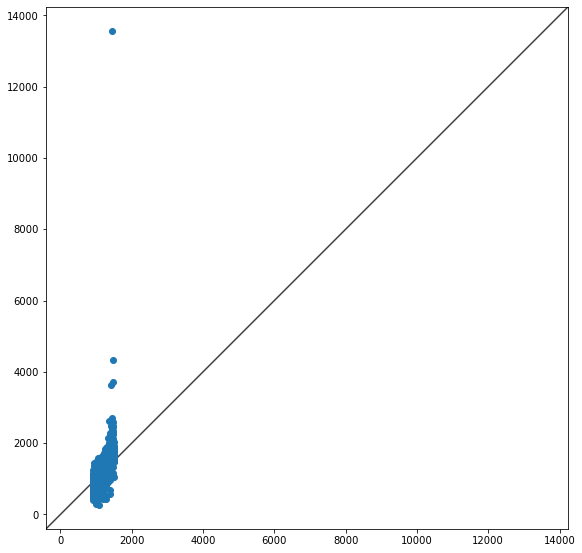

In [386]:
fig, ax = plt.subplots()
ax.scatter(c_train, c_hat_train)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
# ax.set_xlim(lims[0], 3000)
# ax.set_ylim(lims[0], 3000)
ax.set_xlim(lims)
ax.set_ylim(lims)

In [214]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood).double()

model.eval()
# Get distribution & performance on X_test before training
untrained_pred_dist = likelihood(model(X_test))
init_nlpd = gpytorch.metrics.negative_log_predictive_density(untrained_pred_dist, y_test)
init_srmse = standardized_rmse(untrained_pred_dist, y_test)

In [215]:
# List model parameters
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')
    
# Set parameter constraints
# likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.Interval(0,100))
likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.GreaterThan(150))
# model.covar_module.base_kernel.register_constraint("raw_lengthscale", gpytorch.constraints.LessThan(1))

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.raw_constant                   value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


In [216]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 2000

nlls = []
lengthscales = []
noises = []
srmses = []
nlpds = []

# -------- TRAIN -------- 
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Train NLL: %.3f   Lengthscale: %.3f   Noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    nlls.append(loss.item())
    lengthscales.append(model.covar_module.base_kernel.lengthscale.item())
    noises.append(model.likelihood.noise.item())
    
    # -------- EVALUATION -------- 
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Returns the GP latent function at X_test
        f_preds = model(X_test)
        # Returns the marginal distribution(s) at X_test
        y_pred_dist = likelihood(model(X_test))

        f_mean = f_preds.mean
        f_var = f_preds.variance
        f_covar = f_preds.covariance_matrix
        
        final_srmse = standardized_rmse(y_pred_dist, y_test)
        final_nlpd = gpytorch.metrics.negative_log_predictive_density(y_pred_dist, y_test)
        
        # f_srmse = standardized_rmse(y_pred_dist, y_test, f_var, toggle=True)
        # print(f_srmse)
        print(f'Untrained model SRMSE: {init_srmse:.2f}, Trained model SRMSE: {final_srmse}')
        print(f'Untrained model NLPD: {init_nlpd:.2f}, Trained model NLPD: {final_nlpd:.2f}')
        srmses.append(final_srmse)
        nlpds.append(final_nlpd)
        
    
    model.train()
    likelihood.train()
    
    optimizer.step()

Iter 1/2000 - Train NLL: 694.348   Lengthscale: 0.693   Noise: 150.693
Untrained model SRMSE: 110.54, Trained model SRMSE: 22.945448494776528
Untrained model NLPD: 5899.72, Trained model NLPD: 257.48
Iter 2/2000 - Train NLL: 688.949   Lengthscale: 0.744   Noise: 150.744
Untrained model SRMSE: 110.54, Trained model SRMSE: 22.573488358444227
Untrained model NLPD: 5899.72, Trained model NLPD: 248.63
Iter 3/2000 - Train NLL: 683.632   Lengthscale: 0.798   Noise: 150.798
Untrained model SRMSE: 110.54, Trained model SRMSE: 22.21325190518888
Untrained model NLPD: 5899.72, Trained model NLPD: 240.31
Iter 4/2000 - Train NLL: 678.500   Lengthscale: 0.854   Noise: 150.855
Untrained model SRMSE: 110.54, Trained model SRMSE: 21.871905073643045
Untrained model NLPD: 5899.72, Trained model NLPD: 232.64
Iter 5/2000 - Train NLL: 673.639   Lengthscale: 0.911   Noise: 150.913
Untrained model SRMSE: 110.54, Trained model SRMSE: 21.5548923779932
Untrained model NLPD: 5899.72, Trained model NLPD: 225.70
Ite

In [285]:
path = r'models/model1.pth'
torch.save(model.state_dict(), path)

In [243]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Returns the GP latent function at X_test
    f_preds = model(X_test)
    # Returns the (approximate) predictive posterior distribution at X_test
    y_pred_dist = likelihood(model(X_test))

    f_mean = f_preds.mean
    f_var = f_preds.variance
    f_stddev = f_preds.stddev
    f_covar = f_preds.covariance_matrix
    
    init_nlpd = gpytorch.metrics.negative_log_predictive_density(untrained_pred_dist, y_test)
    final_nlpd = gpytorch.metrics.negative_log_predictive_density(y_pred_dist, y_test)
    
    init_srmse = standardized_rmse(untrained_pred_dist, y_test)
    final_srmse = standardized_rmse(y_pred_dist, y_test)
    print(f'Untrained Model SRMSE: {init_srmse:.2f}, Trained Model SRMSE: {final_srmse:.2f}')
    
    # f_srmse = standardized_rmse(y_pred_dist, y_test, f_var, toggle=True)
    # print(f_srmse)
    
    print(f'Untrained model NLPD: {init_nlpd:.2f}, Trained model NLPD: {final_nlpd:.2f}')

Untrained Model SRMSE: 110.54, Trained Model SRMSE: 6.32
Untrained model NLPD: 5899.72, Trained model NLPD: 22.37


In [ ]:
path = r'visualizations'

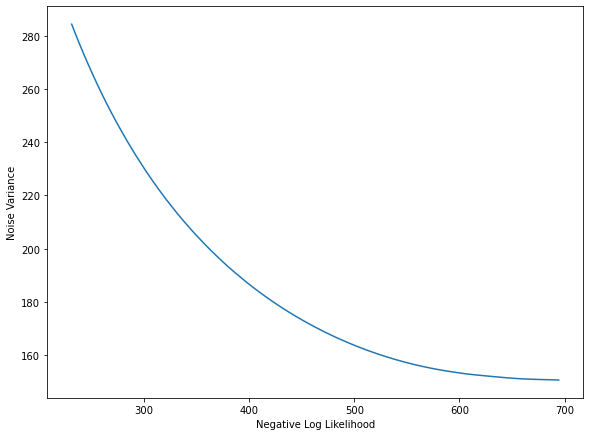

In [291]:
plt.plot(nlls, noises)
plt.ylabel("Noise Variance")
plt.xlabel("Negative Log Likelihood")
path = f''
# plt.savefig(path)
plt.show()

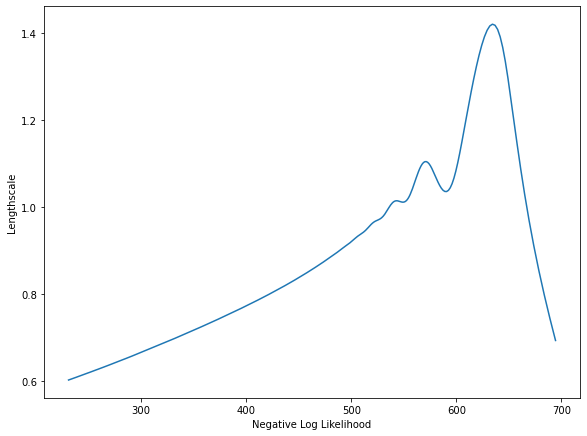

In [272]:
plt.plot(nlls, lengthscales)
plt.ylabel("Lengthscale")
plt.xlabel("Negative Log Likelihood")
plt.show()

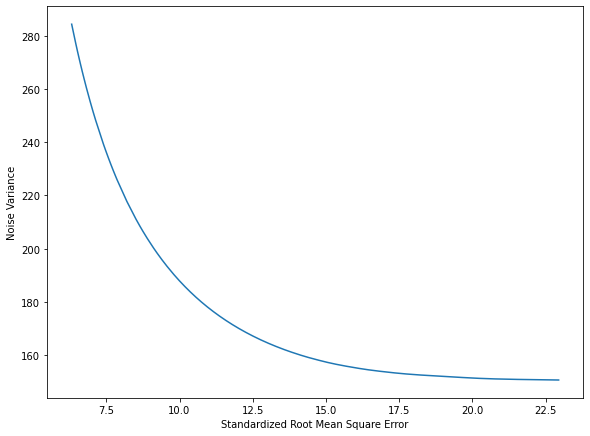

In [273]:
plt.plot(srmses, noises)
plt.ylabel("Noise Variance")
plt.xlabel("Standardized Root Mean Square Error")
plt.show()

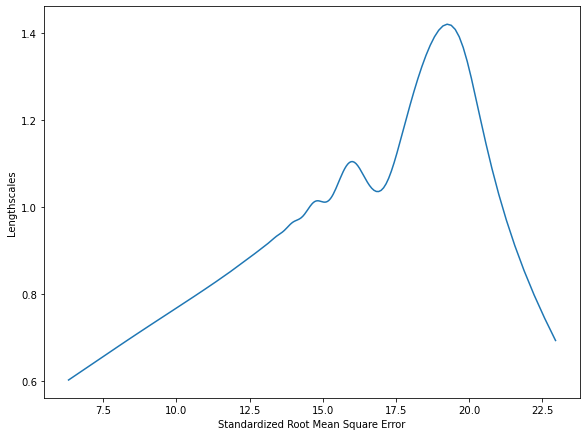

In [274]:
plt.plot(srmses, lengthscales)
plt.ylabel("Lengthscales")
plt.xlabel("Standardized Root Mean Square Error")
plt.show()

(-2717.1892189983923, 851.7503820995113)

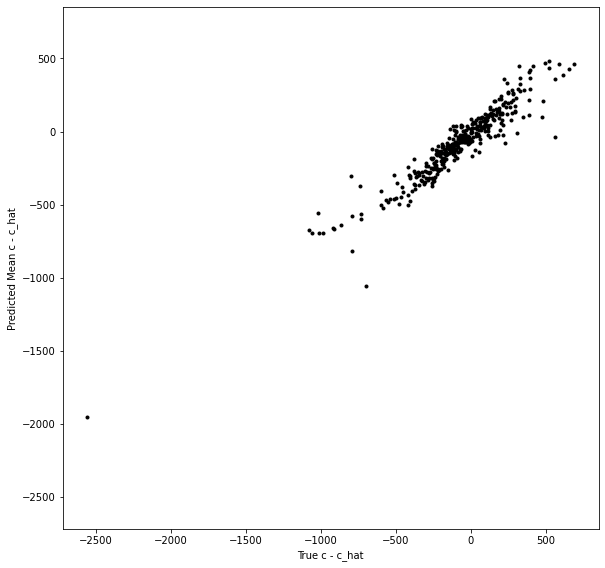

In [313]:
plt.errorbar(y_test, f_mean, yerr=f_stddev, fmt='.k', ecolor='red', dash_capstyle='butt')
plt.xlabel("True c - c_hat")
plt.ylabel("Predicted Mean c - c_hat")
yleft, yright = plt.ylim()
xleft, xright = plt.xlim()
minleft = min(xleft, yleft)
maxright = max(xright, yright)
plt.xlim(minleft, maxright)
plt.ylim(maxleft, maxright)

(-1250.0, 600.0)

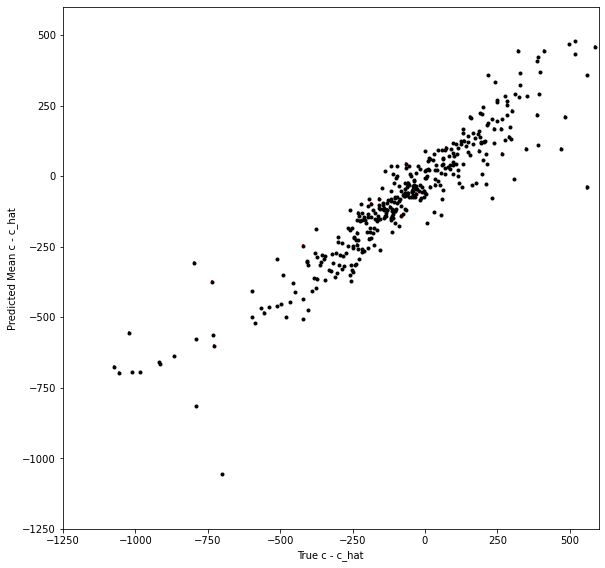

In [299]:
plt.errorbar(y_test, f_mean, yerr=f_stddev, fmt='.k', ecolor='red', dash_capstyle='butt')
plt.xlabel("True c - c_hat")
plt.ylabel("Predicted Mean c - c_hat")
plt.xlim(-1250, 600)
plt.ylim(-1250, 600)

(-500.0, 200.0)

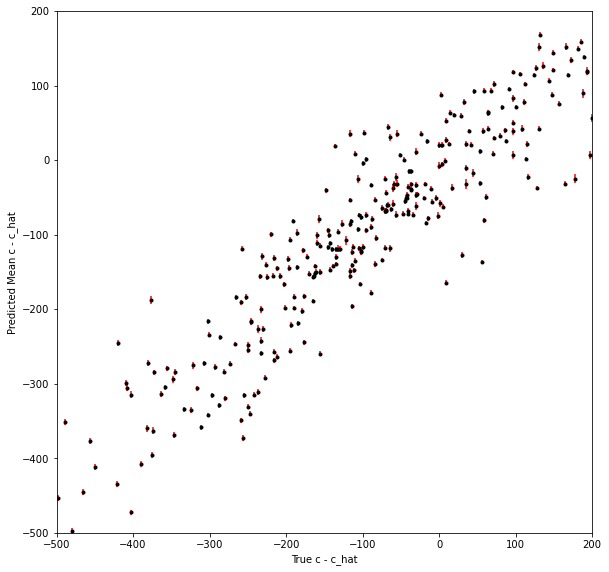

In [301]:
plt.errorbar(y_test, f_mean, yerr=f_stddev, fmt='.k', ecolor='red', dash_capstyle='butt')
plt.xlabel("True c - c_hat")
plt.ylabel("Predicted Mean c - c_hat")
plt.xlim(-500, 200)
plt.ylim(-500, 200)

(-100.0, 0.0)

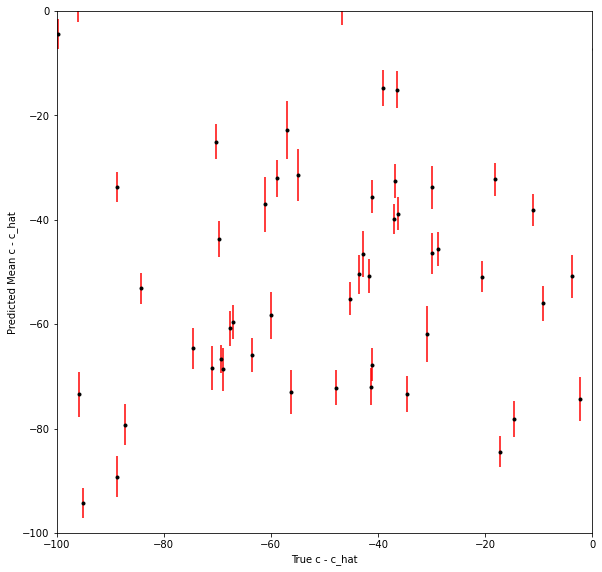

In [316]:
plt.errorbar(y_test, f_mean, yerr=f_stddev, fmt='.k', ecolor='red', dash_capstyle='butt')
plt.xlabel("True c - c_hat")
plt.ylabel("Predicted Mean c - c_hat")
plt.xlim(-100, 0)
plt.ylim(-100, 0)

In [ ]:
# with torch.no_grad():
#     # Initialize plot
#     f, ax = plt.subplots(1, 1, figsize=(5, 4))

#     # Get upper and lower confidence bounds
#     lower, upper = y_pred_dist.confidence_region()
#     # Plot training data as black stars
#     ax.plot(X_train.numpy(), y_train.numpy(), 'k*')
#     # Plot predictive means as blue line
#     ax.plot(X_test.numpy(), y_pred_dist.mean.numpy(), 'b')
#     # Shade between the lower and upper confidence bounds
#     ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
#     ax.set_ylim([-3, 3])
#     ax.legend(['Observed Data', 'Mean', 'Confidence'])